# Download and extract Data

The dataset used in the study can be downloaded from https://data.mendeley.com/datasets/dbjyfkn6jr/1

Augmented dataset download and Extract

In [2]:
!gdown --id 1r6lDHxKOjdJZwH2dfP__NWCVufeLyxOA
!unzip -qq "Tea_leaf.zip"

Downloading...
From: https://drive.google.com/uc?id=1Z1oVacQmbdb3_TISgn1qRPtn79L2Q2R8
To: /content/Tea_leaf.zip
9.03MB [00:00, 79.6MB/s]


# Import libraries and define functions

In [4]:
%tensorflow_version 1.x
!pip install -U efficientnet
import efficientnet.keras as efn 
from keras.applications.densenet   import DenseNet201
from keras.applications.vgg16   import VGG16
from keras.applications.mobilenet   import MobileNet
from keras.applications.resnet50   import ResNet50
from keras.applications.resnet_v2   import ResNet152V2
from keras.applications.xception   import Xception
from keras.applications.inception_v3   import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from skimage.transform import rotate
import numpy as np
import pandas as pd
from shutil import copyfile
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
from sklearn.svm import SVC
import numpy as np
from scipy.ndimage import zoom
from sklearn.preprocessing import StandardScaler
import pickle
from joblib import dump, load
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression,f_classif
from sklearn.feature_selection import RFE
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,plot_confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig("confusion matrix_best.jpg", dpi=150)
    plt.show()    

DATA_FOLDER_TRAIN = "/content/Tea_leaf/train data"
DATA_FOLDER_TEST = "/content/Tea_leaf/test data"
DATA_SAVE_FOLDER = "ExtractedFeatures"
TARGET_NAMES = ['Tea red leaf spot', 'Tea red scab', 'Tea leaf blight']

Requirement already up-to-date: efficientnet in /usr/local/lib/python3.7/dist-packages (1.1.1)


# Extract feature from pre-trained networks

In [5]:
use_saved_extracted_feature = False #@param {type:"boolean"}
if use_saved_extracted_feature:
  train_file_names = np.load(os.path.join(DATA_SAVE_FOLDER,"train_file_names.npy"))
  test_file_names = np.load(os.path.join(DATA_SAVE_FOLDER,"test_file_names.npy"))

  train_labels = np.load(os.path.join(DATA_SAVE_FOLDER,"train_labels.npy"))
  test_labels = np.load(os.path.join(DATA_SAVE_FOLDER,"test_labels.npy"))

  denseXTrain = np.load(os.path.join(DATA_SAVE_FOLDER,"denseXTrain.npy"))
  efficient0XTrain = np.load(os.path.join(DATA_SAVE_FOLDER,"efficient0XTrain.npy"))
  vgg16XTrain = np.load(os.path.join(DATA_SAVE_FOLDER,"vgg16XTrain.npy"))
  resnetXTrain = np.load(os.path.join(DATA_SAVE_FOLDER,"resnetXTrain.npy"))

  denseXTest = np.load(os.path.join(DATA_SAVE_FOLDER,"denseXTest.npy"))
  efficient0XTest = np.load(os.path.join(DATA_SAVE_FOLDER,"efficient0XTest.npy"))
  vgg16XTest = np.load(os.path.join(DATA_SAVE_FOLDER,"vgg16XTest.npy"))
  resnetXTest = np.load(os.path.join(DATA_SAVE_FOLDER,"resnetXTest.npy"))
else:
  train_images = []
  train_labels = []
  train_file_names = []

  dictLabel = {'Tea red leaf spot':0, 'Tea red scab':1, 'Tea leaf blight':2}

  for root, dirs, files in os.walk(DATA_FOLDER_TRAIN, topdown=False):
    for file in files:
      img = image.load_img(os.path.join(root,file), target_size=(224, 224,3))
      train_images.append(image.img_to_array(img))
      train_labels.append(dictLabel[os.path.split(root)[-1]])
      train_file_names.append(os.path.join(root,file))

  test_images = []
  test_labels = []
  test_file_names = []

  for root, dirs, files in os.walk(DATA_FOLDER_TEST, topdown=False):
    for file in files:
      img = image.load_img(os.path.join(root,file), target_size=(224, 224,3))
      test_images.append(image.img_to_array(img))
      test_labels.append(dictLabel[os.path.split(root)[-1]])    
      test_file_names.append(os.path.join(root,file))

  train_images = np.array(train_images)
  test_images = np.array(test_images)
  train_labels = np.array(train_labels)
  test_labels = np.array(test_labels)
  train_file_names = np.array(train_file_names)
  test_file_names = np.array(test_file_names)

  from keras.applications.densenet import preprocess_input
  model = DenseNet201(weights='imagenet',include_top=True)
  denseXTrain = model.predict(preprocess_input(train_images))

  from keras.applications.vgg16 import preprocess_input
  model = VGG16(weights='imagenet',include_top=True)
  vgg16XTrain = model.predict(preprocess_input(train_images))

  model = efn.EfficientNetB0(weights='imagenet',include_top=True)
  efficient0XTrain = model.predict(efn.preprocess_input(train_images))

  from keras.applications.resnet_v2 import preprocess_input
  model = ResNet152V2(weights='imagenet',include_top=True)
  resnetXTrain = model.predict(preprocess_input(train_images))

  from keras.applications.densenet import preprocess_input
  model = DenseNet201(weights='imagenet',include_top=True)
  denseXTest = model.predict(preprocess_input(test_images))

  from keras.applications.vgg16 import preprocess_input
  model = VGG16(weights='imagenet',include_top=True)
  vgg16XTest = model.predict(preprocess_input(test_images))

  model = efn.EfficientNetB0(weights='imagenet',include_top=True)
  efficient0XTest = model.predict(efn.preprocess_input(test_images))

  from keras.applications.resnet_v2 import preprocess_input
  model = ResNet152V2(weights='imagenet',include_top=True)
  resnetXTest = model.predict(preprocess_input(test_images))

x_train = np.concatenate((denseXTrain,efficient0XTrain,vgg16XTrain,resnetXTrain),axis = 1)
y_train = train_labels
x_test = np.concatenate((denseXTest,efficient0XTest,vgg16XTest,resnetXTest),axis = 1)
y_test = test_labels

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# f-classif Feature Selection

In [11]:
use_saved_selected_feature = True #@param {type:"boolean"}
if use_saved_selected_feature:
  fclassifFeatures = np.load(os.path.join(DATA_SAVE_FOLDER,
                                      'fclassifFeatures.npy'))
else:
  KBest = SelectKBest(f_classif, k=2000)
  KBest.fit_transform(x_train, y_train)
  fclassifFeatures = KBest.get_support(indices=True)

# RFE Feature Selection

In [7]:
use_saved_selected_feature = True #@param {type:"boolean"}
if use_saved_selected_feature:
  RFEFeatures = np.load(os.path.join(DATA_SAVE_FOLDER,
                                      'RFEFeatures.npy'))
else:
  rfe = RFE(estimator=SVC(kernel="linear"), n_features_to_select=2000)
  rfe = rfe.fit(x_train,y_train)
  RFEFeatures = rfe.get_support(indices=True)  

# Intersect Selected Features

In [12]:
selectedFeatures =np.intersect1d(fclassifFeatures, RFEFeatures)

# SVM Classification and Test

In [13]:
x_train_secilmis = x_train[:,selectedFeatures]
x_test_secilmis = x_test[:,selectedFeatures]

classifier =  SVC(kernel="linear")
classifier.fit(x_train_secilmis, y_train)

y_head = classifier.predict(x_test_secilmis)

score = accuracy_score(y_test, y_head)
print(score)

1.0


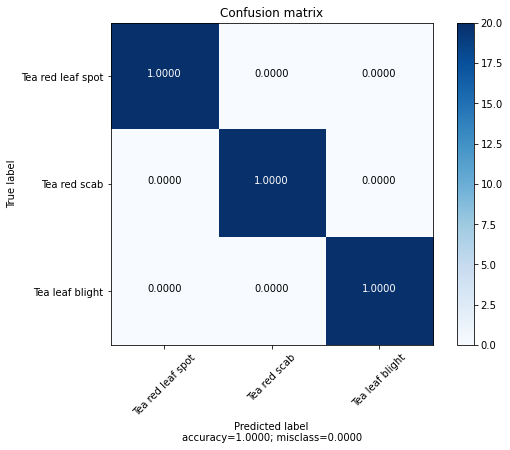

In [10]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_head)
plot_confusion_matrix(cm,['Tea red leaf spot', 'Tea red scab', 'Tea leaf blight'])